In [20]:
import numpy as np
from PIL import Image
import cv2 #opencv
import io
import time
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (30, 30)
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import clear_output
from random import randint
import os
import mss
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
#keras imports
%matplotlib inline 
from keras.models import model_from_json
from ast import literal_eval
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD , Adam
from keras.callbacks import TensorBoard
from collections import deque
import random
import pickle
from io import BytesIO
import base64
import json

In [21]:
#path variables
game_url = "file:///home/paperspace/Chrome-Dino-Reinforcement-Learning/game/dino.html"
chrome_driver_path = "../chromedriver"
loss_file_path = "./objects/loss_df.csv"
actions_file_path = "./objects/actions_df.csv"
q_value_file_path = "./objects/q_values.csv"
scores_file_path = "./objects/scores_df.csv"

In [22]:
'''
* Game class: Selenium interfacing between the python and browser
* __init__():  Launch the broswer window using the attributes in chrome_options
* get_crashed() : return true if the agent as crashed on an obstacles. Gets javascript variable from game decribing the state
* get_playing(): true if game in progress, false is crashed or paused
* restart() : sends a signal to browser-javascript to restart the game
* press_up(): sends a single to press up get to the browser
* get_score(): gets current game score from javascript variables.
* pause(): pause the game
* resume(): resume a paused game if not crashed
* end(): close the browser and end the game
'''
class Game:
    def __init__(self,custom_config=True):
        chrome_options = Options()
        chrome_options.add_argument("disable-infobars")
        chrome_options.add_argument("--mute-audio")
        #chrome_options.add_argument('--headless')
        self._driver = webdriver.Chrome(executable_path = chrome_driver_path,chrome_options=chrome_options)
        self._driver.set_window_position(x=-10,y=0)
        self._driver.get('chrome://dino')
        self._driver.execute_script("Runner.config.ACCELERATION=0")
        self._driver.execute_script(init_script)
        #modifying game before trainNetworkining
    def get_crashed(self):
        return self._driver.execute_script("return Runner.instance_.crashed")
    def get_playing(self):
        return self._driver.execute_script("return Runner.instance_.playing")
    def restart(self):
        self._driver.execute_script("Runner.instance_.restart()")
        
        time.sleep(0.25)# no actions are possible 
                        # for 0.25 sec after game starts, 
                        # skip learning at this time and make the model wait
    def press_up(self):
        self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)
    def get_score(self):
        score_array = self._driver.execute_script("return Runner.instance_.distanceMeter.digits")
        score = ''.join(score_array) # the javascript object is of type array with score in the formate[1,0,0] which is 100.
        return int(score)
    def pause(self):
        return self._driver.execute_script("return Runner.instance_.stop()")
    def resume(self):
        return self._driver.execute_script("return Runner.instance_.play()")
    def end(self):
        self._driver.close()

In [23]:
class DinoAgent:
    def __init__(self,game): #takes game as input for taking actions
        self._game = game; 
        self.jump(); #to start the game, we need to jump once
        time.sleep(1) # no action can be performed for the first time when game starts
    def is_running(self):
        return self._game.get_playing()
    def is_crashed(self):
        return self._game.get_crashed()
    def jump(self):
        self._game.press_up()
    def duck(self):
        self._game.press_down()

In [24]:
class Game_sate:
    def __init__(self,agent,game):
        self._agent = agent
        self._game = game
        self._display = show_img() #display the processed image on screen using openCV, implemented using python coroutine 
        self._display.__next__() # initiliaze the display coroutine 
    def get_state(self,actions):
        actions_df.loc[len(actions_df)] = actions[1] # storing actions in a dataframe
        score = self._game.get_score() 
        reward = 0.1
        is_over = False #game over
        if actions[1] == 1:
            self._agent.jump()
        image = grab_screen(self._game._driver) 
        #self._display.send(image) #display the image on screen
        if self._agent.is_crashed():
            scores_df.loc[len(loss_df)] = score # log the score when game is over
            self._game.restart()
            reward = -1
            is_over = True
        return image, reward, is_over #return the Experience tuple

In [25]:
def save_obj(obj, name ):
    with open('objects/'+ name + '.pkl', 'wb') as f: #dump files into objects folder
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name ):
    with open('objects/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
sct = mss.mss()
monitor = {'top': 120, 'left': 100, 'width': 500, 'height': 400}
def grab_screen(_driver = None):
    if(_driver==None):
        screen = np.array(sct.grab(monitor)) 
    else:
        
        image_b64 = _driver.execute_script(getbase64Script)
        screen = np.array(Image.open(BytesIO(base64.b64decode(image_b64))))
    image = process_img(screen)#processing image as required
    return image

def process_img(image):
    #game is already in grey scale canvas, canny to get only edges and reduce unwanted objects(clouds)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image[:300, :500]
#     image = cv2.Canny(image, threshold1 = 80, threshold2 = 255) #apply the canny edge detection
    image = cv2.resize(image, (80,80))
#     image = cv2.GaussianBlur(image,(5,5),0)
#     cv2.dilate(image,(11,11))
    
     # resale image dimensions

    return  image
def show_img(graphs = False):
    """
    Show images in new window
    """
    while True:
        screen = (yield)
        window_title = "logs" if graphs else "game_play"
        cv2.namedWindow(window_title, cv2.WINDOW_NORMAL)        
        imS = cv2.resize(screen, (800, 400)) 
        cv2.imshow(window_title, screen)
        if (cv2.waitKey(1) & 0xFF == ord('q')):
            cv2.destroyAllWindows()
            break

(80, 80)

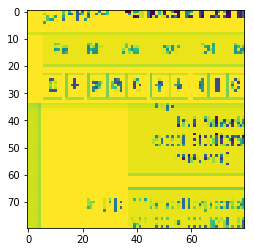

In [26]:
plt.imshow(grab_screen())
grab_screen().shape

In [27]:
#Intialize log structures from file if exists else create new
loss_df = pd.read_csv(loss_file_path) if os.path.isfile(loss_file_path) else pd.DataFrame(columns =['loss'])
scores_df = pd.read_csv(scores_file_path) if os.path.isfile(loss_file_path) else pd.DataFrame(columns = ['scores'])
actions_df = pd.read_csv(actions_file_path) if os.path.isfile(actions_file_path) else pd.DataFrame(columns = ['actions'])
q_values_df =pd.read_csv(actions_file_path) if os.path.isfile(q_value_file_path) else pd.DataFrame(columns = ['qvalues'])

In [28]:
# training variables saved as checkpoints to filesystem to resume training from the same step
def init_cache():
    """initial variable caching, done only once"""
    save_obj(INITIAL_EPSILON,"epsilon")
    t = 0
    save_obj(t,"time")
    D = deque()
    save_obj(D,"D")

In [29]:
#game parameters
ACTIONS = 2 # possible actions: jump, do nothing
GAMMA = 0.99 # decay rate of past observations original 0.99
OBSERVATION = 100. # timesteps to observe before training
EXPLORE = 100000  # frames over which to anneal epsilon
FINAL_EPSILON = 0.0001 # final value of epsilon
INITIAL_EPSILON = 0.1 # starting value of epsilon
REPLAY_MEMORY = 50000 # number of previous transitions to remember
BATCH = 16 # size of minibatch
FRAME_PER_ACTION = 1
LEARNING_RATE = 1e-4
img_rows , img_cols = 80,80
img_channels = 4 #We stack 4 frames

In [30]:
def buildmodel():
    print("Now we build the model")
    model = Sequential()
#     Conv2D(32, (8, 8), strides=(4, 4), input_shape=(20, 40, 4..., padding="same")`
    model.add(Conv2D(32, (8, 8), padding='same',strides=(4, 4),input_shape=(img_cols,img_rows,img_channels)))  #80*80*4
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (4, 4),strides=(2, 2),  padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3),strides=(1, 1),  padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(ACTIONS))
    adam = Adam(lr=LEARNING_RATE)
    model.compile(loss='mse',optimizer=adam)
    print("We finish building the model")
    return model

In [31]:
''' 
main training module
Parameters:
* model => Keras Model to be trained
* game_state => Game State module with access to game environment and dino
* observe => flag to indicate wherther the model is to be trained(weight updates), else just play
'''
def trainNetwork(model,game_state,observe=False):
    last_time = time.time()
    # store the previous observations in replay memory
    D = load_obj("D") #load from file system
    # get the first state by doing nothing
    do_nothing = np.zeros(ACTIONS)
    do_nothing[0] =1 #0 => do nothing,
                     #1=> jump
    
    x_t, r_0, terminal = game_state.get_state(do_nothing) # get next step after performing the action
    

    s_t = np.stack((x_t, x_t, x_t, x_t), axis=2) # stack 4 images to create placeholder input
    

    
    s_t = s_t.reshape(1, s_t.shape[0], s_t.shape[1], s_t.shape[2])  #1*20*40*4
    
    initial_state = s_t 

    if observe :
        OBSERVE = 999999999    #We keep observe, never train
        epsilon = FINAL_EPSILON
        print ("Now we load weight")
        model.load_weights("model_final.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)
        print ("Weight load successfully")    
    else:                       #We go to training mode
        OBSERVE = OBSERVATION
        epsilon = load_obj("epsilon") 
        model.load_weights("model_final.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)

    t = load_obj("time") # resume from the previous time step stored in file system
    while (True): #endless running
        
        loss = 0
        Q_sa = 0
        action_index = 0
        r_t = 0 #reward at 4
        a_t = np.zeros([ACTIONS]) # action at t
        
        #choose an action epsilon greedy
        if t % FRAME_PER_ACTION == 0: #parameter to skip frames for actions
            if  random.random() <= epsilon: #randomly explore an action
                print("----------Random Action----------")
                action_index = random.randrange(ACTIONS)
                a_t[0] = 1
            else: # predict the output
                q = model.predict(s_t)       #input a stack of 4 images, get the prediction
                max_Q = np.argmax(q)         # chosing index with maximum q value
                action_index = max_Q 
                a_t[action_index] = 1        # o=> do nothing, 1=> jump
                
        #We reduced the epsilon (exploration parameter) gradually
        if epsilon > FINAL_EPSILON and t > OBSERVE:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE 

        #run the selected action and observed next state and reward
        x_t1, r_t, terminal = game_state.get_state(a_t)
        print('fps: {0}'.format(1 / (time.time()-last_time))) # helpful for measuring frame rate
        last_time = time.time()
        x_t1 = x_t1.reshape(1, x_t1.shape[0], x_t1.shape[1], 1) #1x20x40x1
        s_t1 = np.append(x_t1, s_t[:, :, :, :3], axis=3) # append the new image to input stack and remove the first one
        
        
        # store the transition in D
        D.append((s_t, action_index, r_t, s_t1, terminal))
        if len(D) > REPLAY_MEMORY:
            D.popleft()

        #only train if done observing
        if t > OBSERVE: 
            
            #sample a minibatch to train on
            minibatch = random.sample(D, BATCH)
            inputs = np.zeros((BATCH, s_t.shape[1], s_t.shape[2], s_t.shape[3]))   #32, 20, 40, 4
            targets = np.zeros((inputs.shape[0], ACTIONS))                         #32, 2

            #Now we do the experience replay
            for i in range(0, len(minibatch)):
                state_t = minibatch[i][0]    # 4D stack of images
                action_t = minibatch[i][1]   #This is action index
                reward_t = minibatch[i][2]   #reward at state_t due to action_t
                state_t1 = minibatch[i][3]   #next state
                terminal = minibatch[i][4]   #wheather the agent died or survided due the action
                

                inputs[i:i + 1] = state_t    

                targets[i] = model.predict(state_t)  # predicted q values
                Q_sa = model.predict(state_t1)      #predict q values for next step
                
                if terminal:
                    targets[i, action_t] = reward_t # if terminated, only equals reward
                else:
                    targets[i, action_t] = reward_t + GAMMA * np.max(Q_sa)

            loss += model.train_on_batch(inputs, targets)
            loss_df.loc[len(loss_df)] = loss
            q_values_df.loc[len(q_values_df)] = np.max(Q_sa)
        else:
            # artificial time delay as training done with this delay
            time.sleep(0.12)
        s_t = initial_state if terminal else s_t1 #reset game to initial frame if terminate
        t = t + 1
        
        # save progress every 1000 iterations
        if t % 1000 == 0:
            print("Now we save model")
            game_state._game.pause()
            model.save_weights("model_final.h5", overwrite=True)
            save_obj(D,"D") #saving episodes
            save_obj(t,"time") #caching time steps
            save_obj(epsilon,"epsilon") #cache epsilon to avoid repeated randomness in actions
            loss_df.to_csv("./objects/loss_df.csv",index=False)
            scores_df.to_csv("./objects/scores_df.csv",index=False)
            actions_df.to_csv("./objects/actions_df.csv",index=False)
            q_values_df.to_csv(q_value_file_path,index=False)
            with open("model.json", "w") as outfile:
                json.dump(model.to_json(), outfile)
            clear_output()
            game_state._game.resume()
        # print info
        state = ""
        if t <= OBSERVE:
            state = "observe"
        elif t > OBSERVE and t <= OBSERVE + EXPLORE:
            state = "explore"
        else:
            state = "train"

        print("TIMESTEP", t, "/ STATE", state,             "/ EPSILON", epsilon, "/ ACTION", action_index, "/ REWARD", r_t,             "/ Q_MAX " , np.max(Q_sa), "/ Loss ", loss)

    print("Episode finished!")
    print("************************")


In [32]:

def playGame(observe=False):
    game = Game()
    dino = DinoAgent(game)
    game_state = Game_sate(dino,game)    
    model = buildmodel()
    try:
        trainNetwork(model,game_state,observe=observe)
    except StopIteration:
        game.end()

In [33]:
'''tensorflowjsScript = " \
var scc = document.createElement('script'); \
scc.src = 'https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@0.10.0'; \
document.head.appexndChild(scc); "

getTensorScript = "canvasRunner = document.getElementsByClassName('runner-canvas')[0]; \
img_data = tf.fromPixels(canvasRunner); \
return img_data.dataSync().toString()"
'''
init_script = "document.getElementsByClassName('runner-canvas')[0].id = 'runner-canvas'"

getbase64Script = "canvasRunner = document.getElementById('runner-canvas'); \
return canvasRunner.toDataURL().substring(22)"

In [34]:
playGame(observe=False);

TIMESTEP 569000 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.31792 / Loss  0.0145992012694
fps: 0.13889242478530192
TIMESTEP 569001 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.43808 / Loss  0.0169195253402
fps: 4.289702698307664
TIMESTEP 569002 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.38564 / Loss  0.0101879928261
fps: 3.7484317873290025
TIMESTEP 569003 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.47211 / Loss  0.0175344124436
fps: 3.7593036918992606
TIMESTEP 569004 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.36724 / Loss  0.00718937302008
fps: 3.744081896078461
TIMESTEP 569005 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.34915 / Loss  1.31886923313
fps: 4.005133532970727
TIMESTEP 569006 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.

TIMESTEP 569055 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.60035 / Loss  0.0148588195443
fps: 3.5313436655957218
TIMESTEP 569056 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.61529 / Loss  0.00777778867632
fps: 3.736364016986129
TIMESTEP 569057 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.50859 / Loss  0.0097436318174
fps: 3.7486026429576245
TIMESTEP 569058 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.78996 / Loss  0.428435206413
fps: 3.7830794776950682
TIMESTEP 569059 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.75065 / Loss  0.00633329944685
fps: 3.512420287488433
TIMESTEP 569060 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.62671 / Loss  0.00767152383924
fps: 3.762895550882431
TIMESTEP 569061 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  

TIMESTEP 569110 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.37126 / Loss  0.00434330431744
fps: 3.994476327252849
TIMESTEP 569111 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.5682 / Loss  0.00350507115945
fps: 3.755207577914462
TIMESTEP 569112 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.5455 / Loss  0.00658191973343
fps: 3.7812923437535217
TIMESTEP 569113 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  -1.08109 / Loss  0.00595097336918
fps: 3.7586299290356866
TIMESTEP 569114 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.6411 / Loss  0.0575971454382
fps: 3.9925371429441734
TIMESTEP 569115 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.57453 / Loss  3.12003827095
fps: 4.0080997116938395
TIMESTEP 569116 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9

fps: 3.7684502765036996
TIMESTEP 569165 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.54859 / Loss  0.0416489169002
fps: 3.500252861170038
TIMESTEP 569166 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.56544 / Loss  0.0546635054052
fps: 4.027605438505688
TIMESTEP 569167 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.61134 / Loss  0.0020796507597
fps: 3.7567547717359178
TIMESTEP 569168 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.53429 / Loss  0.463397204876
fps: 3.340584281117589
TIMESTEP 569169 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.63712 / Loss  0.00473261997104
fps: 3.162753099936961
TIMESTEP 569170 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.48641 / Loss  0.0130854342133
fps: 3.7682539083591853
TIMESTEP 569171 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 /

fps: 4.290123917701871
TIMESTEP 569220 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.56186 / Loss  0.0103536481038
fps: 3.994240482702402
TIMESTEP 569221 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.66024 / Loss  0.00471709761769
fps: 4.29848200999422
TIMESTEP 569222 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.57117 / Loss  2.97732901573
fps: 3.749809125841053
TIMESTEP 569223 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.50439 / Loss  0.00287721399218
fps: 3.967434209592852
TIMESTEP 569224 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.55616 / Loss  0.00610533962026
fps: 4.025788518407961
TIMESTEP 569225 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.55066 / Loss  0.00241474597715
fps: 4.010636883901721
TIMESTEP 569226 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / R

fps: 3.7713066981249135
TIMESTEP 569275 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.5326 / Loss  0.00960922427475
fps: 4.023413533574938
TIMESTEP 569276 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.48916 / Loss  0.00661083124578
fps: 3.7343613805629627
TIMESTEP 569277 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.46074 / Loss  0.0329386033118
fps: 3.9991838213560387
TIMESTEP 569278 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.43197 / Loss  0.00461804866791
fps: 4.0254176044071
TIMESTEP 569279 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.39785 / Loss  0.00494543835521
fps: 3.489365029845469
TIMESTEP 569280 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.42813 / Loss  0.138755306602
fps: 4.032604619949274
TIMESTEP 569281 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 /

TIMESTEP 569330 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.43075 / Loss  0.0130965933204
fps: 3.984840841183205
TIMESTEP 569331 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.33993 / Loss  0.0164310336113
fps: 3.9952106668393927
TIMESTEP 569332 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.22989 / Loss  0.00589111447334
fps: 3.5309571955085843
TIMESTEP 569333 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.45398 / Loss  0.2137042135
fps: 3.5305351479114617
TIMESTEP 569334 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.42309 / Loss  2.36398696899
fps: 3.7450112547557035
TIMESTEP 569335 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.37133 / Loss  0.00919565558434
fps: 3.536751214247167
TIMESTEP 569336 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.39

TIMESTEP 569385 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.31138 / Loss  0.00210287421942
fps: 3.751563261673591
TIMESTEP 569386 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.23584 / Loss  0.0280430298299
fps: 4.272268630233124
TIMESTEP 569387 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.26675 / Loss  0.138571977615
fps: 4.265659959807663
TIMESTEP 569388 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.39285 / Loss  0.00915808044374
fps: 4.048352785381429
TIMESTEP 569389 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.16568 / Loss  1.61158573627
fps: 3.503395809092967
TIMESTEP 569390 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.24633 / Loss  0.0146642103791
fps: 3.787277691896499
TIMESTEP 569391 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.3047

fps: 3.987113639712348
TIMESTEP 569440 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  8.71769 / Loss  0.0252311974764
fps: 3.5276785789380725
TIMESTEP 569441 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.07111 / Loss  0.0344551056623
fps: 3.985810251551588
TIMESTEP 569442 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  8.25237 / Loss  0.0243177674711
fps: 3.753812833099893
TIMESTEP 569443 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  8.94705 / Loss  0.0454102531075
fps: 3.528981574733852
TIMESTEP 569444 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  8.76327 / Loss  0.106841757894
fps: 4.0135689754658
TIMESTEP 569445 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  8.92775 / Loss  0.0575261414051
fps: 4.023459847936903
TIMESTEP 569446 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWA

fps: 4.025212858250608
TIMESTEP 569495 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.79769 / Loss  0.00632646912709
fps: 3.7550831850896222
TIMESTEP 569496 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.75787 / Loss  0.0338364206254
fps: 3.976435119786877
TIMESTEP 569497 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.7525 / Loss  0.00515508884564
fps: 4.025699647368896
TIMESTEP 569498 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  9.72564 / Loss  0.00508285500109
fps: 3.52059871021462
TIMESTEP 569499 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.55795 / Loss  0.0125072505325
fps: 3.7498158306929774
TIMESTEP 569500 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  9.50144 / Loss  0.0106308544055
fps: 3.756875910264288
TIMESTEP 569501 / STATE train / EPSILON 9.999999987391849e-05 / ACTION 0 /

WebDriverException: Message: chrome not reachable
  (Session info: chrome=62.0.3202.62)
  (Driver info: chromedriver=2.35.528139 (47ead77cb35ad2a9a83248b292151462a66cd881),platform=Linux 4.4.0-31-generic x86_64)


In [ ]:
()